### Importing Libraries


In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.utils import resample
import os
import timm
import glob
from datetime import datetime

In [3]:
train = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_ids.csv")
train_dir = "train"
test_dir = "test"
print(train.head())
print(test.head())

           image_id      soil_type
0  img_ed005410.jpg  Alluvial soil
1  img_0c5ecd2a.jpg  Alluvial soil
2  img_ed713bb5.jpg  Alluvial soil
3  img_12c58874.jpg  Alluvial soil
4  img_eff357af.jpg  Alluvial soil
            image_id
0  img_cdf80d6f.jpeg
1   img_c0142a80.jpg
2   img_91168fb0.jpg
3   img_9822190f.jpg
4  img_e5fc436c.jpeg


### Preprocessing the Image Data and Loading Train/Test Data


In [4]:
soil_type_dict = dict(zip(train['image_id'], train['soil_type']))

train_data_list = []
for image_id in train['image_id']:
    image_path = os.path.join(train_dir, image_id)
    if os.path.exists(image_path):
        image = Image.open(image_path).convert("RGB").resize((224, 224))
        soil_type = soil_type_dict[image_id]
        train_data_list.append(
            {'image_id': image_id, 'image_data': image, 'soil_type': soil_type})

train_data = pd.DataFrame(train_data_list)

print(train_data.head())

           image_id                                         image_data  \
0  img_ed005410.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...   
1  img_0c5ecd2a.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...   
2  img_ed713bb5.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...   
3  img_12c58874.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...   
4  img_eff357af.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...   

       soil_type  
0  Alluvial soil  
1  Alluvial soil  
2  Alluvial soil  
3  Alluvial soil  
4  Alluvial soil  


In [5]:
test_data = pd.DataFrame()

test_data_dict = {}
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        image = Image.open(image_path).convert("RGB").resize((224, 224))
        test_data_dict[filename] = image

test_data_list = []
for image_id in test['image_id']:
    if image_id in test_data_dict:
        test_data_list.append({'image_id': image_id, 'image_data': test_data_dict[image_id]})

test_data = pd.DataFrame(test_data_list)

print(test_data.head())

            image_id                                         image_data
0  img_cdf80d6f.jpeg  <PIL.Image.Image image mode=RGB size=224x224 a...
1   img_c0142a80.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...
2   img_91168fb0.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...
3   img_9822190f.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...
4  img_e5fc436c.jpeg  <PIL.Image.Image image mode=RGB size=224x224 a...


### Converting Soil Types into Integers


In [6]:
unique_soil_types = train_data['soil_type'].unique()

In [7]:
soil_type_mapping = {soil: idx for idx, soil in enumerate(unique_soil_types)}
print(soil_type_mapping)

train_data['soil_type'] = train_data['soil_type'].map(soil_type_mapping)

{'Alluvial soil': 0, 'Clay soil': 1, 'Red soil': 2, 'Black Soil': 3}


### Visualizing the train data


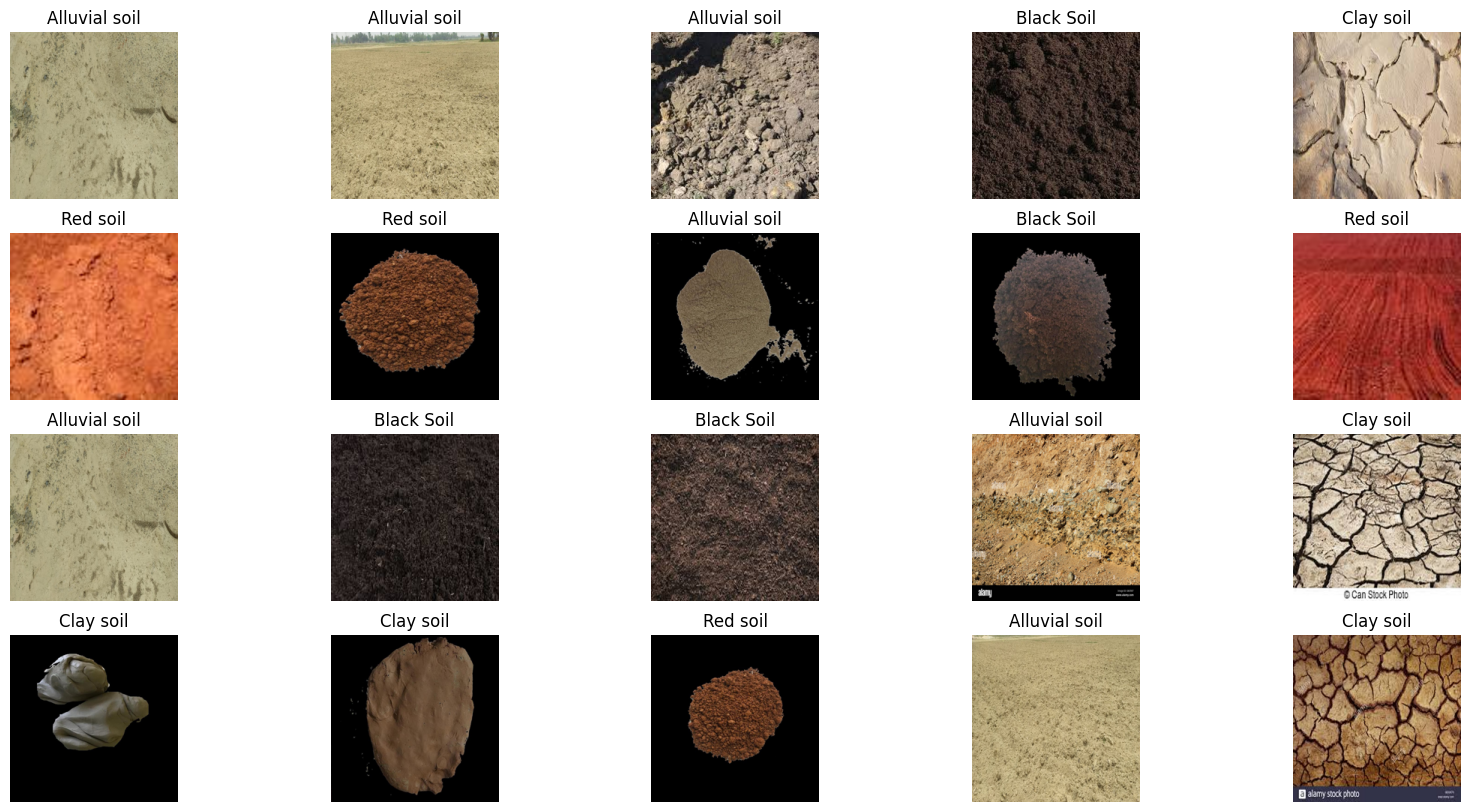

In [8]:
# Visualizing 20 random images from the training dataset
def visualize_data(data, num_images=20, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(data), size=num_images, replace=False)
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(idxs):
        plt.subplot(4, 5, i + 1)
        plt.imshow(data['image_data'].iloc[idx])
        label_idx = data['soil_type'].iloc[idx]
        label_name = [k for k, v in soil_type_mapping.items()
                      if v == label_idx][0]
        plt.title(label_name)
        plt.axis('off')
    plt.show()


visualize_data(train_data, num_images=20)

In [9]:
# print train and test data shapes
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1222, 3)
Test data shape: (341, 2)


### SOIL DataSet Class


In [10]:
class SoilDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data['image_data'].iloc[idx]
        if 'soil_type' in self.data.columns:
            label = self.data['soil_type'].iloc[idx]
        else:
            label = -1

        if self.transform:
            image = self.transform(image)

        return image, label

### Checking for Class Imbalance


Alluvial soil: 528
Clay soil: 199
Red soil: 264
Black Soil: 231


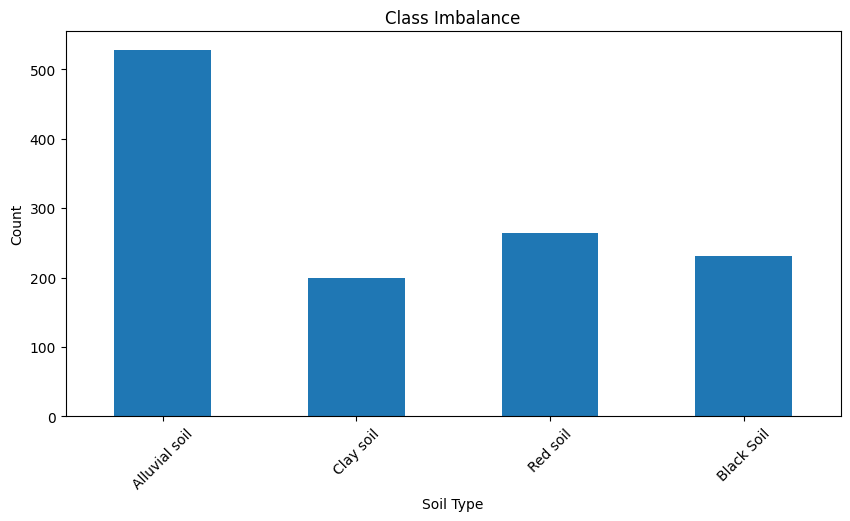

In [11]:
# check for class imbalance
def check_class_imbalance(data):
    class_counts = data['soil_type'].value_counts().sort_index()
    for idx, count in class_counts.items():
        soil_name = [k for k, v in soil_type_mapping.items() if v == idx][0]
        print(f"{soil_name}: {count}")
    plt.figure(figsize=(10, 5))
    class_counts.plot(kind='bar')
    plt.title('Class Imbalance')
    plt.xlabel('Soil Type')
    plt.ylabel('Count')
    labels = [k for k, v in sorted(
        soil_type_mapping.items(), key=lambda item: item[1])]
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
    plt.show()


check_class_imbalance(train_data)

### Oversample minority classes to fix class imbalance


Alluvial soil: 528
Clay soil: 528
Red soil: 528
Black Soil: 528


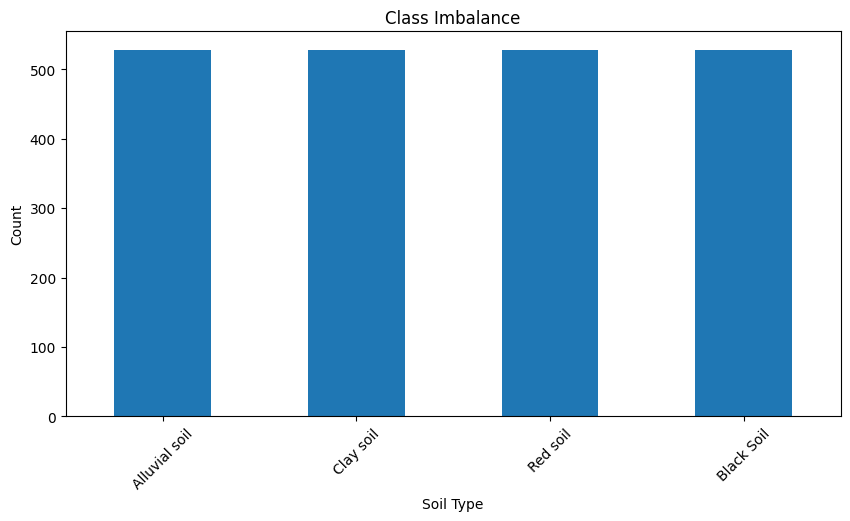

In [12]:
# Seperate by class
dfs = []
for class_idx in range(len(soil_type_mapping)):
    class_df = train_data[train_data['soil_type'] == class_idx]
    dfs.append(class_df)

# Find the maximum class size
max_size = max([len(df) for df in dfs])

# Resample each class to the max size
dfs_balanced = [
    resample(df, replace=True, n_samples=max_size, random_state=42)
    for df in dfs
]

# Concatenate back into a single DataFrame
train_data_balanced = pd.concat(dfs_balanced).reset_index(drop=True)

# Shuffle the balanced dataset
train_data = train_data_balanced.sample(
    frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
check_class_imbalance(train_data)

### Data Augmentation Pipeline and Dataloaders


In [13]:
# create transforms to normalize and augment the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_split, val_split = train_test_split(
    train_data, test_size=0.2, stratify=train_data['soil_type'], random_state=42)

# Create datasets and dataloaders
train_dataset = SoilDataset(train_split, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = SoilDataset(val_split, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = SoilDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### CNN Model


In [14]:
# Squeeze-and-Excitation block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale

# Residual block with SE


class ResidualSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualSEBlock, self).__init__()
        self.same_channels = in_channels == out_channels
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.se = SEBlock(out_channels)
        self.shortcut = (
            nn.Identity() if self.same_channels else nn.Conv2d(
                in_channels, out_channels, kernel_size=1)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv(x)
        out = self.se(out)
        out += identity
        return self.relu(out)

# Final Model


class EnhancedSOILNet(nn.Module):
    def __init__(self, num_classes=4):  # or len(soil_type_mapping)
        super(EnhancedSOILNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            ResidualSEBlock(32, 32),
            nn.MaxPool2d(2)  # 224 -> 112
        )
        self.layer2 = nn.Sequential(
            ResidualSEBlock(32, 64),
            nn.MaxPool2d(2)  # 112 -> 56
        )
        self.layer3 = nn.Sequential(
            ResidualSEBlock(64, 128),
            nn.MaxPool2d(2)  # 56 -> 28
        )
        self.layer4 = nn.Sequential(
            ResidualSEBlock(128, 256),
            nn.MaxPool2d(2)  # 28 -> 14
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x
    
model = EnhancedSOILNet(num_classes=len(soil_type_mapping)).to(device)

In [15]:
from torchvision.models import resnet34, resnet50

model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(soil_type_mapping))
model = model.to(device)

/home/godwildbeast/virtenvs/ml/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/godwildbeast/virtenvs/ml/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model = timm.create_model(
    'convnextv2_base.fcmae_ft_in22k_in1k', pretrained=True).to(device)

In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Training Loop


In [18]:
def calculate_metrics(model, loader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(
        targets, preds, average='macro')
    acc = accuracy_score(targets, preds)
    return acc, precision, recall, f1


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    # Create timestamped output directory
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_dir = os.path.join("checkpoints", timestamp)
    os.makedirs(output_dir, exist_ok=True)

    best_val_loss = float('inf')
    all_metrics = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds, train_targets = [], []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # if scheduler:
        #     scheduler.step()

        # Compute training metrics
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_targets, train_preds, average='macro')
        train_acc = accuracy_score(train_targets, train_preds)
        train_loss = running_loss / len(train_loader)

        # Compute validation metrics
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_acc, val_precision, val_recall, val_f1 = calculate_metrics(
            model, val_loader)

        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
        print(
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Save best model by validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(output_dir, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(
                f"✅ Best model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

        # Store metrics
        all_metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
        })

    # Save all metrics to a CSV
    df_metrics = pd.DataFrame(all_metrics)
    metrics_path = os.path.join(output_dir, "training_metrics.csv")
    df_metrics.to_csv(metrics_path, index=False)
    print(f"📊 Metrics saved to {metrics_path}")

In [19]:
train_model(model, train_loader, val_loader, criterion,
            optimizer, scheduler, num_epochs=30)

OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 3.63 GiB of which 70.88 MiB is free. Including non-PyTorch memory, this process has 3.56 GiB memory in use. Of the allocated memory 3.40 GiB is allocated by PyTorch, and 86.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Visualizing Predictions on Validation Set


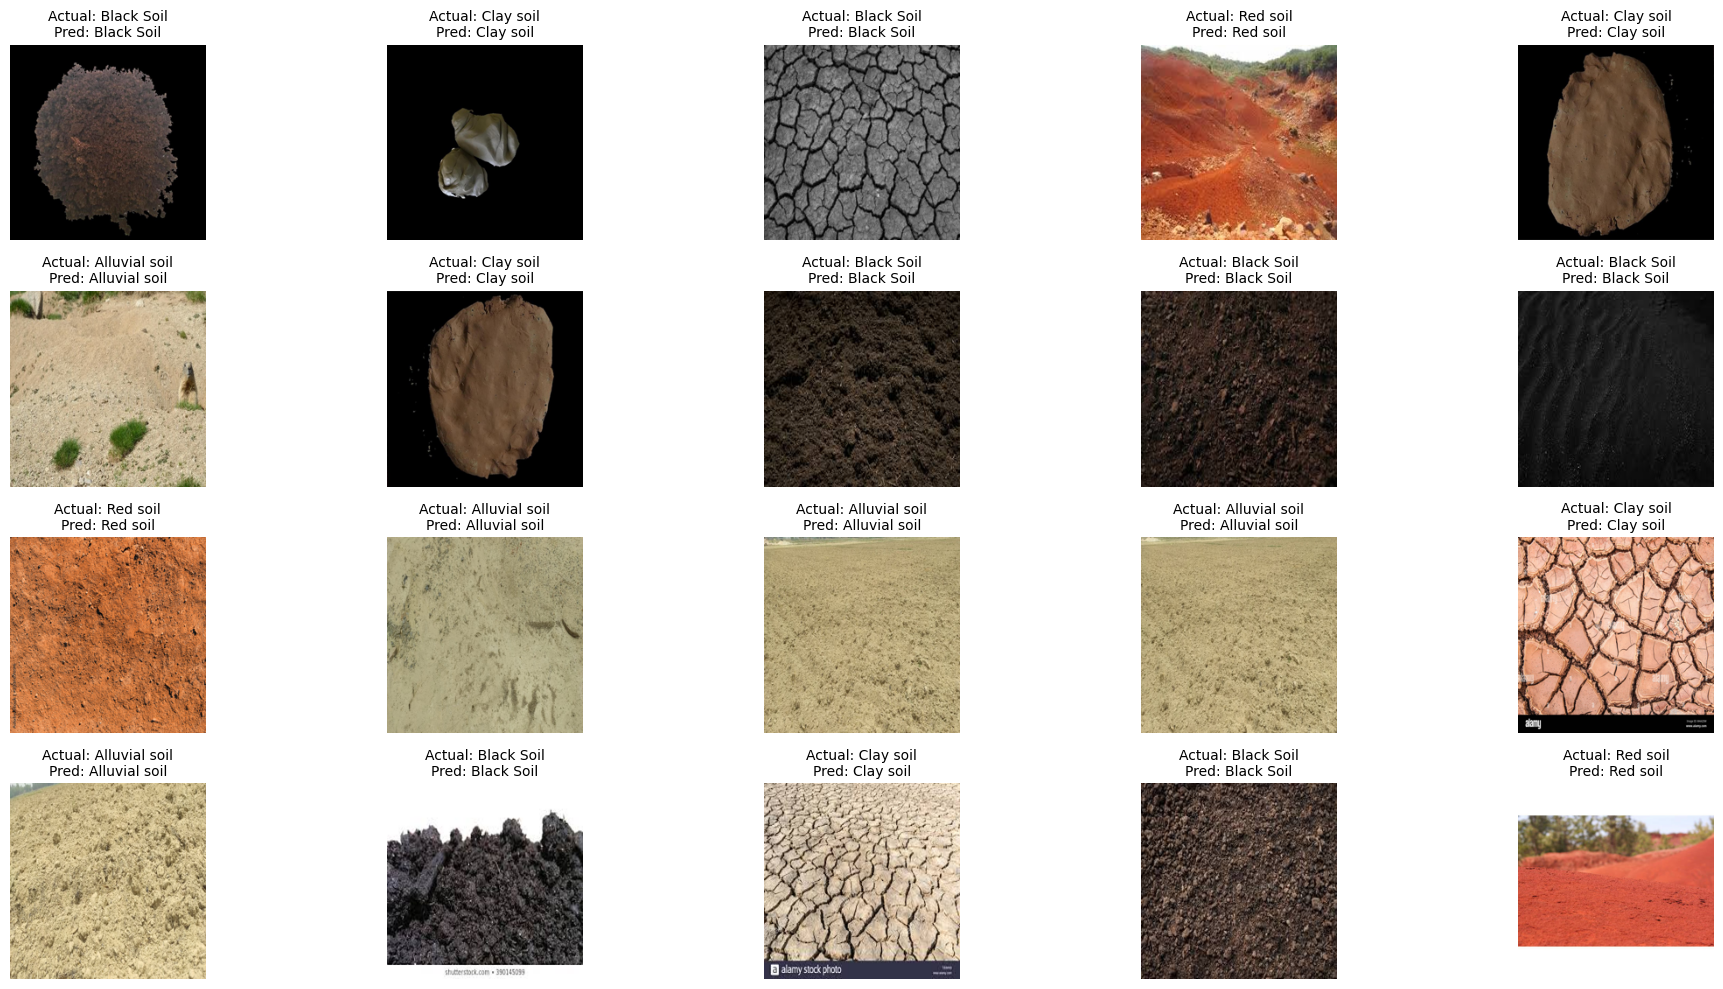

In [24]:
checkpoint_dirs = glob.glob(os.path.join("checkpoints", "*"))
if checkpoint_dirs:
    latest_dir = max(checkpoint_dirs, key=os.path.getmtime)
    best_model_path = os.path.join(latest_dir, "best_model.pth")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
    else:
        print("No best_model.pth found in the latest checkpoint directory.")
else:
    print("No checkpoint directories found.")


def visualize_val_predictions(model, val_loader, num_images=20, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(val_loader.dataset),
                            size=num_images, replace=False)
    plt.figure(figsize=(20, 10))
    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(idxs):
            image, actual_label = val_loader.dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            outputs = model(image_input)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()

            plt.subplot(4, 5, i + 1)
            pil_img = val_loader.dataset.data['image_data'].iloc[idx]
            plt.imshow(pil_img)
            actual_name = [k for k, v in soil_type_mapping.items()
                           if v == actual_label][0]
            predicted_name = [
                k for k, v in soil_type_mapping.items() if v == predicted_label][0]
            plt.title(
                f"Actual: {actual_name}\nPred: {predicted_name}", fontsize=10)
            plt.axis('off')
    plt.tight_layout()
    plt.show()


visualize_val_predictions(model, val_loader, num_images=20)

### VIsualizing Predictions on Test Set


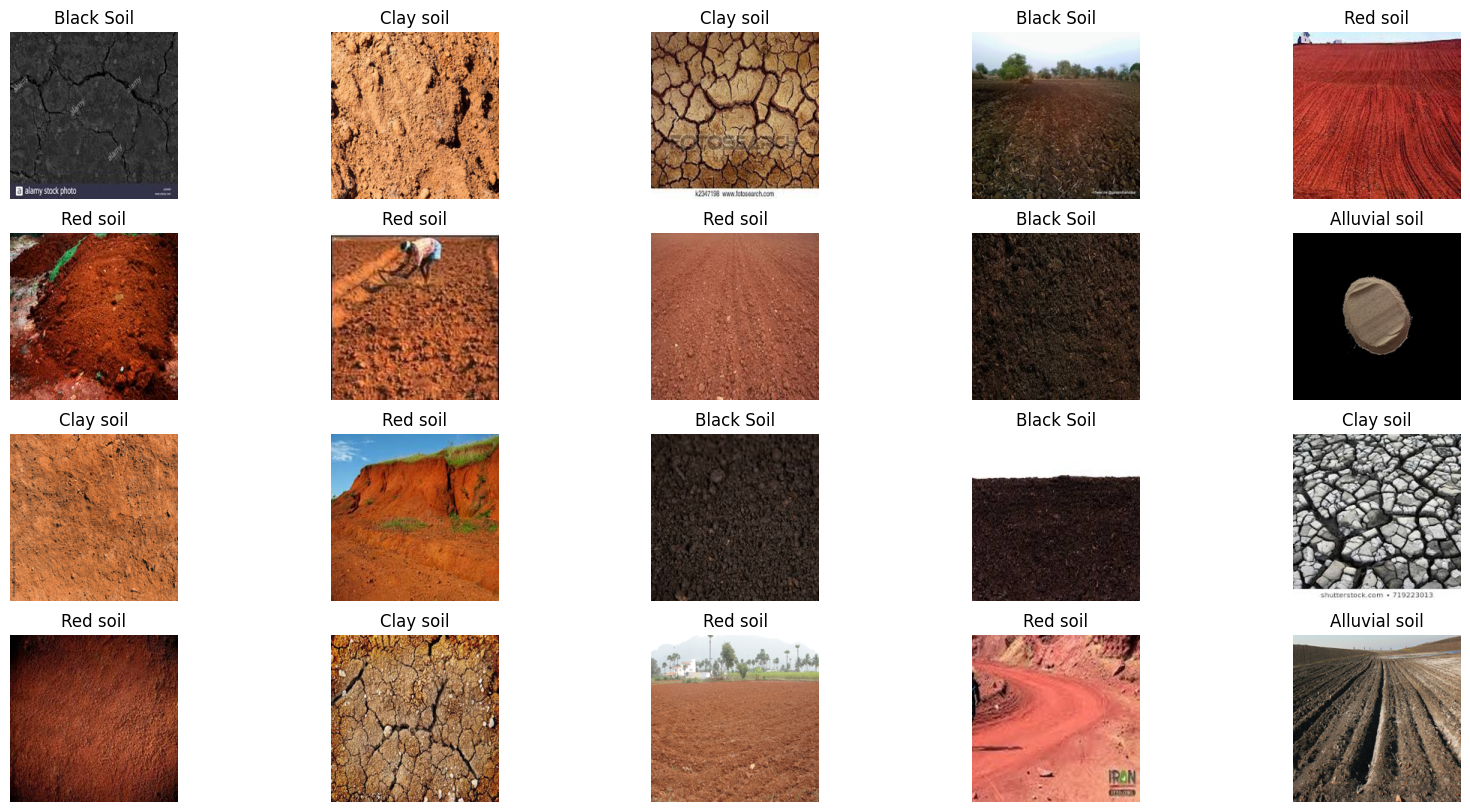

In [ ]:
checkpoint_dirs = glob.glob(os.path.join("checkpoints", "*"))
if checkpoint_dirs:
    latest_dir = max(checkpoint_dirs, key=os.path.getmtime)
    best_model_path = os.path.join(latest_dir, "best_model.pth")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
    else:
        print("No best_model.pth found in the latest checkpoint directory.")
else:
    print("No checkpoint directories found.")


def visualize_predictions(model, test_loader, num_images=20, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(test_loader.dataset),
                            size=num_images, replace=False)
    plt.figure(figsize=(20, 10))
    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(idxs):
            images, _ = test_loader.dataset[idx]
            images = images.unsqueeze(0).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()

            plt.subplot(4, 5, i + 1)
            plt.imshow(test_loader.dataset.data['image_data'].iloc[idx])
            label_name = [k for k, v in soil_type_mapping.items()
                          if v == predicted_label][0]
            plt.title(label_name)
            plt.axis('off')
    plt.show()


visualize_predictions(model, test_loader, num_images=20)

### Confusion Matrix


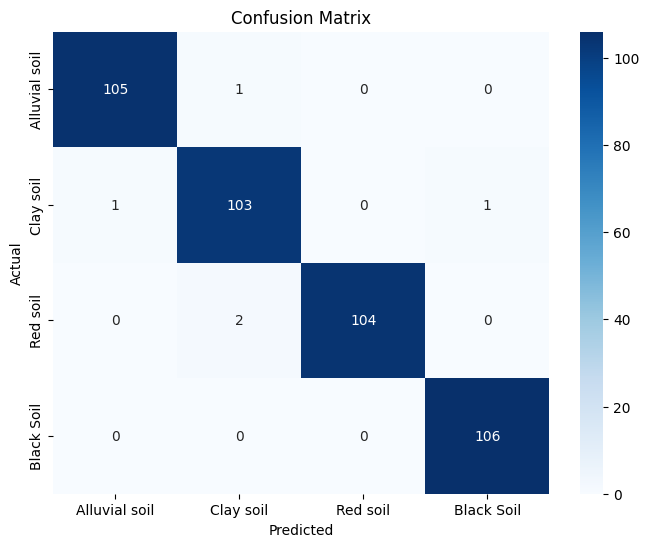

Classification Report:

               precision    recall  f1-score   support

Alluvial soil      0.991     0.991     0.991       106
    Clay soil      0.972     0.981     0.976       105
     Red soil      1.000     0.981     0.990       106
   Black Soil      0.991     1.000     0.995       106

     accuracy                          0.988       423
    macro avg      0.988     0.988     0.988       423
 weighted avg      0.988     0.988     0.988       423



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions and true labels for the validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = [k for k, v in sorted(
    soil_type_mapping.items(), key=lambda item: item[1])]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(
    all_labels, all_preds, target_names=class_names, digits=3)
print("Classification Report:\n")
print(report)

In [ ]:
def generate_submission(model, test_loader, output_path='submission.csv'):
    model.eval()
    preds = []
    image_ids = test_data['image_id'].tolist()

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())

    inv_mapping = {v: k for k, v in soil_type_mapping.items()}
    labels = [inv_mapping[p] for p in preds]

    submission = pd.DataFrame({'image_id': image_ids, 'soil_type': labels})
    submission.to_csv(output_path, index=False)


checkpoint_dirs = glob.glob(os.path.join("checkpoints", "*"))
if checkpoint_dirs:
    latest_dir = max(checkpoint_dirs, key=os.path.getmtime)
    best_model_path = os.path.join(latest_dir, "best_model.pth")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
    else:
        print("No best_model.pth found in the latest checkpoint directory.")
else:
    print("No checkpoint directories found.")

generate_submission(model, test_loader, output_path='submission.csv')

In [ ]:
# Generate predictions for all test images and add as a column
model.eval()
model.load_state_dict(torch.load(best_model_path))
test_preds = []
with torch.no_grad():
    for i in range(len(test_data)):
        image = test_data['image_data'].iloc[i]
        image_tensor = transform(image).unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        test_preds.append(predicted.item())

test_data['predictions'] = test_preds

# Visualize all predictions in a 5*n grid (where n is enough to show all images)
def visualize_all_test_predictions(test_data):
    num_images = len(test_data)
    cols = 5
    rows = int(np.ceil(num_images / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(test_data['image_data'].iloc[i])
        label_idx = test_data['predictions'].iloc[i]
        label_name = [k for k, v in soil_type_mapping.items() if v == label_idx][0]
        plt.title(label_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_all_test_predictions(test_data)